In [1]:
import numpy as np
from scipy.io import wavfile
from scipy import linalg as la
from scipy import signal
from glob import glob
import librosa
import IPython
from matplotlib import pyplot as plt
from matplotlib import colors
import simpleaudio as sa
from hmmlearn import hmm
from importlib import reload
import IPython
import warnings

In [2]:
def get_music_filenames(path, ext=".mp3"):
    for filen in glob(path+"/**/*"+ext):
        yield filen

def export(filename, data, sr, normalize=True):
    if normalize:
        data = data/np.max(np.abs(data))
    data = (data * (2**15-1)).astype(int).astype(np.int16)
    wavfile.write(filename, sr, data)

In [3]:
def analyze_frequencies(sound, sr, base_hz=440, steps_down=24, steps_up=24):
    """
    Returns the t, frequency, and CWT values from the given sound with the given sample rate
    """
    freq = base_hz * 2 **(np.arange(-steps_down,steps_up+1)/12) # in Hz
    
    t = np.arange(len(sound)) / sr
    w = 40.
    widths = w*sr / (2*freq*np.pi)
    cwtm = signal.cwt(sound, signal.morlet2, widths, w=w)
    plt.figure(figsize=(16,5))
    plt.pcolormesh(t, np.log(freq), np.abs(cwtm), cmap='viridis', shading='nearest',
                   norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, base=10))
    plt.colorbar()
    plt.show()
    return t,freq,cwtm

In [4]:
def back_to_sound(t, cwt, freqs):
    vals = np.sin(2*np.pi*t.reshape(1,-1) * freqs.reshape(-1,1))
    return np.mean(vals * np.abs(cwt) / np.max(np.abs(cwt)), axis=0)

In [5]:
def split_into_windows(cwtm, window_ms, sr, window_func, output_dim):
    """
    Condenses the coefficients over windows.
    Input shape is (n_freqs, n_samples)
    Output shape is (n_windows, n_freqs, output_dim)
    """
    cwtm = np.abs(cwtm)
    window_size = (window_ms*sr)//1000
    n_freqs = cwtm.shape[0]
    n_windows = cwtm.shape[1] // window_size
    t = np.linspace(0,1,window_size)
    
    out = np.empty((n_windows, n_freqs, output_dim))
    
    for i in range(n_windows):
        out[i,:,:] = window_func(t, cwtm[:,i*window_size:(i+1)*window_size])
    return out

def return_from_windows(cwtm_coefs, window_ms, sr, window_func):
    """
    Turns condensed windows back into CWT coefficients
    Input shape is (n_windows, n_freqs, output_dim)
    Output shape is (n_freqs, n_samples)
    """
    cwtm_coefs = np.atleast_3d(cwtm_coefs)
    window_size = (window_ms*sr)//1000
    n_freqs = cwtm_coefs.shape[1]
    n_windows = cwtm_coefs.shape[0]
    n_samples = window_size * n_windows
    t = np.linspace(0,1,window_size)
    
    out = np.empty((n_freqs, n_samples))
    
    for i in range(n_windows):
        point = window_size * i
        out[:,point:point+window_size] = window_func(t, cwtm_coefs[i,:,:], window_size)
    return out

In [6]:
def initialize(n_states, k_list=[], scale=0.1):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += np.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    transmat[transmat < 0] = 0
    for k in k_list:
        transmat += np.eye(n_states, k=k)*scale
    transmat /= np.sum(transmat, axis=1).reshape(-1,1)
    startprob = np.ones(n_states)/float(n_states) + np.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

In [43]:
filenames = list(get_music_filenames('WTK-data'))
music0, sr = librosa.load(filenames[5], sr=(44100//15))
dt = 1 / sr

C:\Users\losti\anaconda3\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [44]:
music0.shape

(1493935,)

# Time for some models?

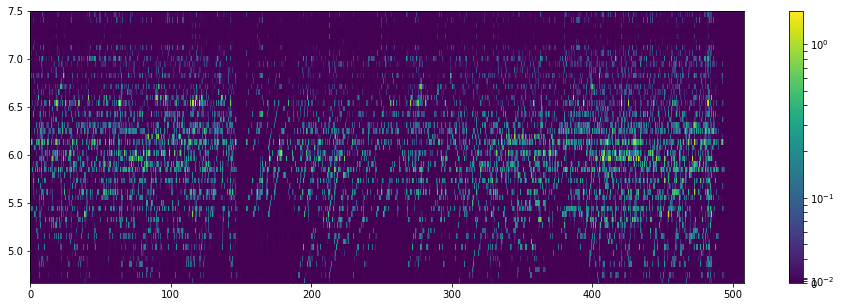

In [45]:
t,freq,cwtm = analyze_frequencies(music0, sr, base_hz=440)

In [46]:
ms_window = 120
mean_vals = split_into_windows(cwtm, ms_window, sr, lambda t,x: np.mean(x, axis=1).reshape(-1,1), 1)
mean_vals = mean_vals[:,:,0]
is_zero = np.max(mean_vals, axis=1) < 1e-1
mean_vals = mean_vals[~is_zero]
n_windows = mean_vals.shape[0]
mean_vals /= np.sum(mean_vals, axis=1).reshape(-1,1)

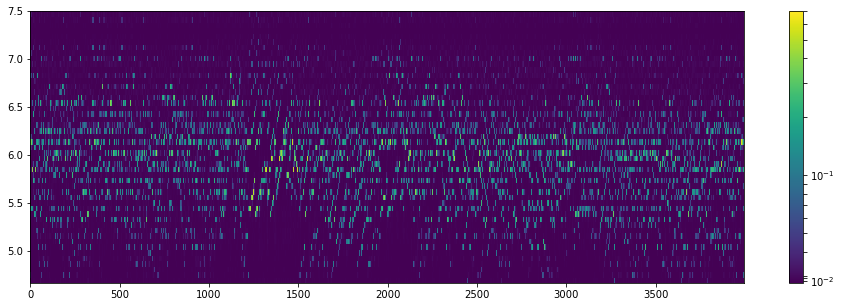

In [47]:
plt.figure(figsize=(16,5))
plt.pcolormesh(np.arange(n_windows), np.log(freq), mean_vals.T, cmap='viridis', shading='nearest',
               norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, base=10))
plt.colorbar()
plt.show()

In [74]:
tol = 1e-3
logmean = np.zeros_like(mean_vals)
mask = mean_vals > tol
logmean[mask] = np.log(mean_vals[mask])
logmean[~mask] = np.log(tol)

In [75]:
#hmm = reload(hmm)

use_log = True
m = len(freq)
n_components = 120
#n_mix = 3
covar_prior = 1e-2
var = 1e-8
# Train the GMMHMM
warnings.filterwarnings("error", category=RuntimeWarning)
startprob, transmat = initialize(n_components, [0,0,0,0,0,1,2,3,4,8,12,16,-16,-30,-31,-32,-33],scale=0.15)
model = hmm.GaussianHMM(n_components=n_components, transmat_prior=transmat, startprob_prior=startprob,
                         covariance_type='diag', covars_prior=np.full((n_components,1), covar_prior),
#                        covariance_type='full', 
#                        covars_prior=np.ones((n_components,1,1))*covar_prior*np.eye(m).reshape(1,m,m), 
                        min_covar=var, params='tmc', n_iter=100)
if use_log:
    model.fit(logmean)
else:
    model.fit(mean_vals)
    
mask = np.sum(model.transmat_, axis=1) == 0.
print(np.sum(mask))
model.transmat_[mask,:] = 1/n_components
warnings.filterwarnings("always", category=RuntimeWarning)

Some rows of transmat_ have zero sum because no transition from the state was ever observed.


5


In [77]:
start_state = np.random.random(model.n_components)
start_state /= np.sum(start_state)
model.startprob_ = start_state
if use_log:
    new_log_samples, states = model.sample(200)
    print(np.max(new_log_samples), np.min(new_log_samples))
    new_samples = np.exp(new_log_samples)
    new_samples[new_samples < tol*10] = 0.
else:
    new_samples, states = model.sample(200)
    new_samples = np.abs(new_samples)

0.4597091188055469 -8.556273610774284


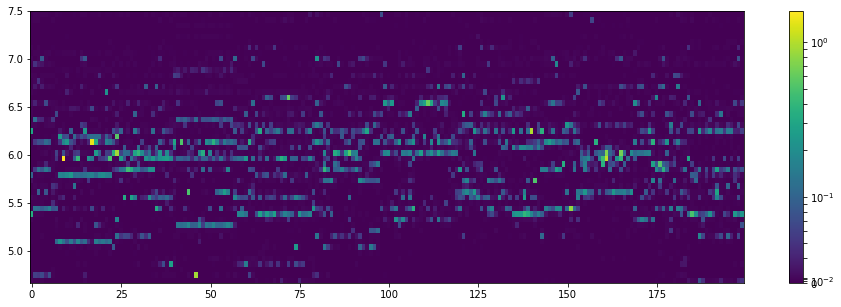

In [78]:
plt.figure(figsize=(16,5))
plt.pcolormesh(np.arange(new_samples.shape[0]), np.log(freq), new_samples.T, cmap='viridis', shading='nearest',
               norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03, base=10))
plt.colorbar()
plt.show()

In [81]:
new_sr = 44100//2
new_samples_continuous = return_from_windows(new_samples, ms_window, new_sr, lambda t,x,n: x.reshape(-1,1)+np.zeros((1,n)))
new_samples_continuous /= (np.sum(new_samples_continuous, axis=1).reshape(-1,1)+1e-4)
new_t = np.arange(new_samples_continuous.shape[1]) / new_sr

In [82]:
print(new_t.shape, new_samples.shape, new_samples_continuous.shape)
#size = min(new_t.shape[0], new_samples_continuous.shape[1])

(529200,) (200, 49) (49, 529200)


In [83]:
new_sound = back_to_sound(new_t, new_samples_continuous, freq)
export("help_15.wav", new_sound, new_sr)